# Loading necessary libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from sklearn.utils import shuffle

from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import  RandomNormal
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
%matplotlib inline
from tensorflow.keras.preprocessing import image

import pandas as pd

from skimage import feature
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

from keras.layers import Input, concatenate
from keras.models import Model

# Checking if GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading and preprocessing images

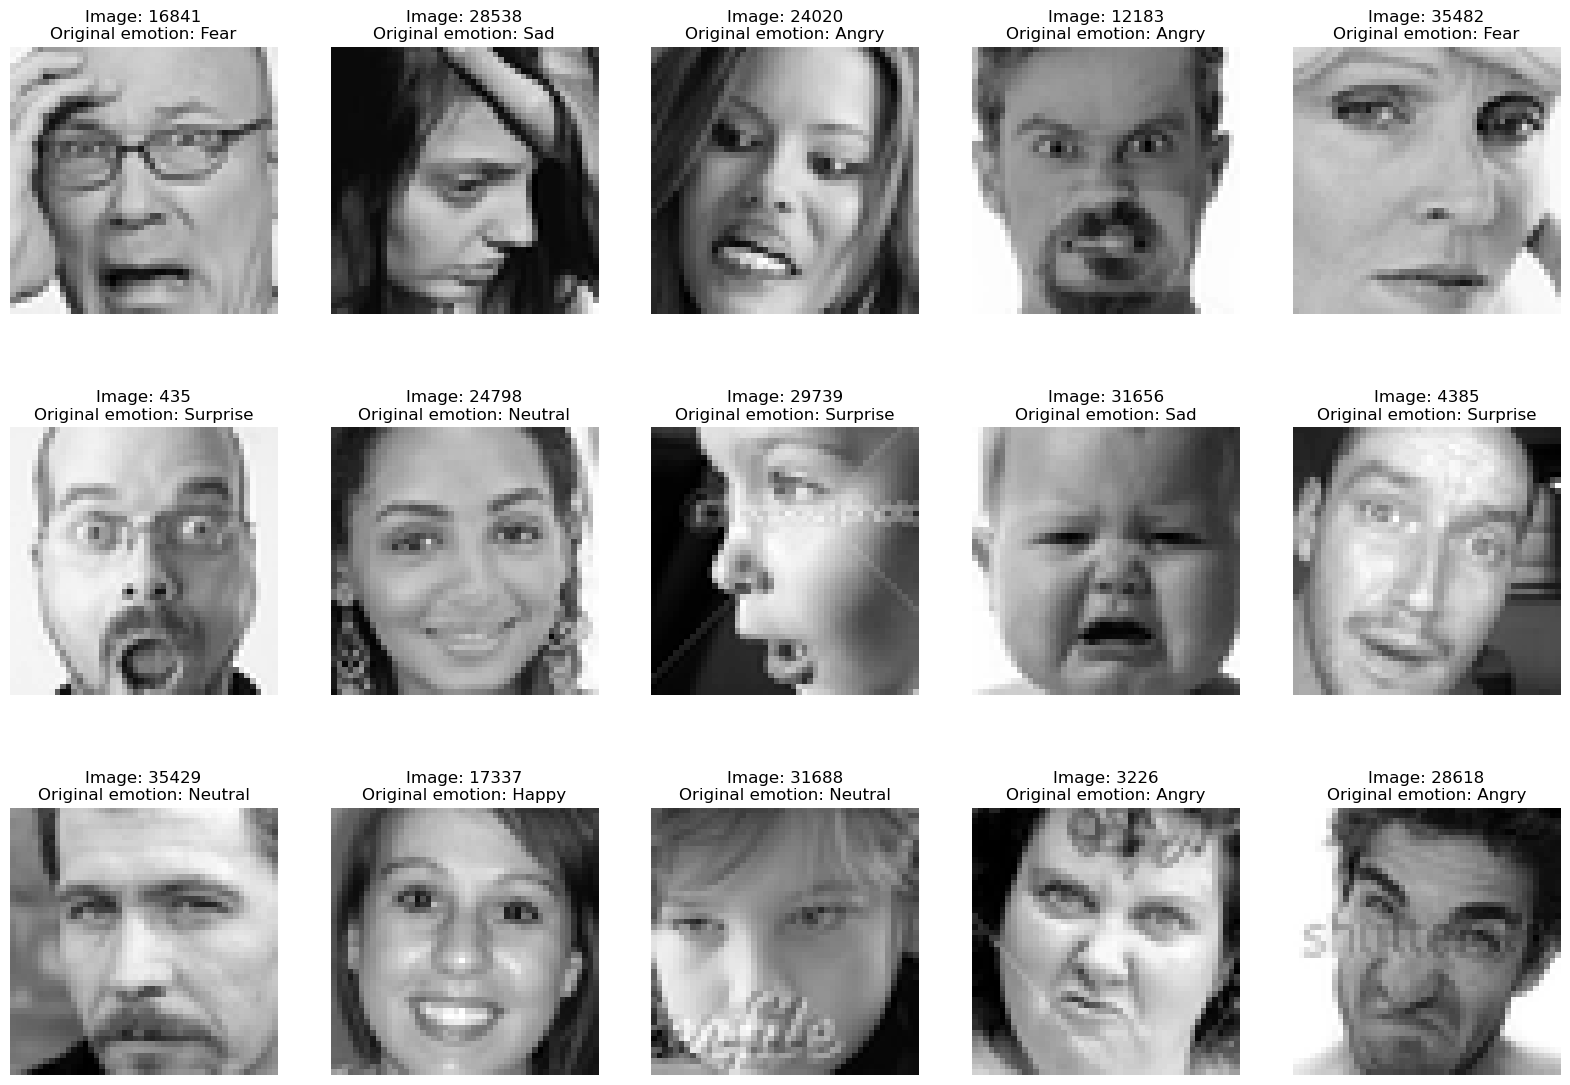

In [2]:
data = pd.read_csv("../fer2013.csv")

emotions_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
data['emotion_name'] = data['emotion'].map(emotions_names)

pixels_values = data['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()]).tolist()
pixels_values = pd.DataFrame(pixels_values, dtype=int)
images = pixels_values.values
images = images.astype(float)


test_idx_start = 32298
images_test = images[test_idx_start:]


# Function for displaying 15 random images
def show_random(imgs, emotion_nms_org=None, emotion_nms_pred=None, random=True, indices=None):
    
    if random:
        indices = np.random.randint(0, len(imgs), size=15)
    else:
        indices = np.random.choice(list(indices), size=15, replace=False)
    plt.figure(figsize=(20, 14)) 
    for index, number in enumerate(indices):
        plt.subplot(3, 5, index + 1)
        if (emotion_nms_org is None and emotion_nms_pred is None):
            plt.title('Image: ' + str(indices[index]))           
        elif (emotion_nms_org is None and emotion_nms_pred is not None):
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        elif (emotion_nms_org is not None and emotion_nms_pred is None):
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]])           
        else:
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]] + 
                      '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        show_image = imgs[number].reshape(48, 48)
        plt.axis('off')
        plt.imshow(show_image, cmap='gray')


show_random(images, emotion_nms_org=data['emotion_name'])

# Standardizing images
each_pixel_mean = images.mean(axis=0)
each_pixel_std = np.std(images, axis=0)
images = np.divide(np.subtract(images, each_pixel_mean), each_pixel_std)

image_pixels = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)
labels_flat = data["emotion"].values.ravel()
labels_count = np.unique(labels_flat).shape[0]


# Function for creating zero/ones matrix indicating image label
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot


labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)


In [3]:
images = images.reshape(images.shape[0], 48, 48, 1)
images = images.astype('float32')

# Splitting images and labels into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = False)

In [4]:
train = len(images)
test = len(images_test)

print("train:", train)
print("test:", test)
nama_kelas = list(emotions_names.values())
print(nama_kelas)

train: 35887
test: 3589
['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


In [5]:
# Total train/test sample
class_counts = data['emotion_name'].value_counts()

# Cetak jumlah setiap kelas
print(class_counts)

emotion_name
Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
Name: count, dtype: int64


In [6]:
# Count class occurrences in train and test data
train_labels = data.iloc[:test_idx_start]['emotion']
test_labels = data.iloc[test_idx_start:]['emotion']

train_class_counts = train_labels.value_counts().sort_index()
test_class_counts = test_labels.value_counts().sort_index()
totalTrain = sum(train_labels)
totalTest = sum(test_labels)

print("Jumlah sampel setiap kelas (Train):")
print(train_class_counts)
print("total test", totalTrain)

print("\nJumlah sampel setiap kelas (Test):")
print(test_class_counts)
print("total test", totalTest)

# Visualisasi
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# train_class_counts.plot(kind='bar', title='Jumlah Sampel per Kelas (Train)')
# plt.xlabel('Emosi')
# plt.ylabel('Jumlah Sampel')

# plt.subplot(1, 2, 2)
# test_class_counts.plot(kind='bar', title='Jumlah Sampel per Kelas (Test)')
# plt.xlabel('Emosi')
# plt.ylabel('Jumlah Sampel')

# plt.tight_layout()
# plt.show()


Jumlah sampel setiap kelas (Train):
emotion
0    4462
1     492
2    4593
3    8110
4    5483
5    3586
6    5572
Name: count, dtype: int64
total test 107302

Jumlah sampel setiap kelas (Test):
emotion
0    491
1     55
2    528
3    879
4    594
5    416
6    626
Name: count, dtype: int64
total test 11960


# Building LBP

In [7]:
def calculate_lbp(image):
    # Konversi gambar ke citra grayscale jika belum dalam format grayscale
    if len(image.shape) == 3:
        image = image[:,:,0]  # Ambil saluran pertama (grayscale)
    
    # Hitung LBP menggunakan scikit-image
    radius = 1
    num_points = 8 * radius
    lbp_image = feature.local_binary_pattern(image, num_points, radius, method='uniform')
    
    return lbp_image


# Hitung LBP untuk gambar yang sesuai dengan format
valid_images = [image for image in images if len(image.shape) == 2]
lbp_images = [calculate_lbp(image) for image in valid_images]
lbp_images = np.array(lbp_images, dtype=np.uint8)


In [8]:
lbp_images = lbp_images.reshape(lbp_images.shape[0], 48, 48, 1)


In [9]:
from keras.layers import concatenate

In [10]:
# Mengembalikan gambar ke bentuk (48, 48)
images = images.reshape(images.shape[0], 48, 48)

# Create LBP images for X_train
lbp_images_train = []

for image in X_train:
    lbp_image = calculate_lbp(image)
    lbp_images_train.append(lbp_image)

# Convert lbp_images_train to a numpy array and reshape it
lbp_images_train = np.array(lbp_images_train)
lbp_images_train = lbp_images_train.reshape(X_train.shape[0], 48, 48, 1)

# Pastikan lbp_images_train memiliki jumlah sampel yang sama dengan X_train
if len(lbp_images_train) != len(X_train):
    raise ValueError("Jumlah sampel dalam lbp_images_train tidak sesuai dengan X_train")



C:\Users\hp\.conda\envs\tensorflowgpu\lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [11]:
print("Jumlah sampel X_train:", len(X_train))
print("Jumlah sampel lbp_images_train:", len(lbp_images_train))



Jumlah sampel X_train: 29068
Jumlah sampel lbp_images_train: 29068


# Building CNN LBP

In [12]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate

# Bagian pertama: Membuat model VGG16 untuk citra grayscale
model = Sequential()

# Layer 1 (grayscale input)
model.add(Conv2D(64, (3, 3), input_shape=(48, 48, 1), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Bagian kedua: Membuat model untuk citra LBP
lbp_input = Input(shape=(48, 48, 1), name='lbp_input')
x_lbp = Conv2D(64, (3, 3), activation='relu', padding='same')(lbp_input)
x_lbp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_lbp)
x_lbp = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x_lbp)

# Menggabungkan output dari kedua bagian
output_vgg = model.layers[-1].output
x_lbp = Flatten()(x_lbp)
num_lbp_features = x_lbp.shape[-1]
output_vgg = Flatten()(output_vgg)
num_vgg_features = output_vgg.shape[-1]

# Sesuaikan dimensi output dari model VGG16 dengan Flatten dari model VGG16
x_lbp = Dense(num_vgg_features, activation='relu')(x_lbp)

combined = concatenate([output_vgg, x_lbp])

# Fully connected layers untuk klasifikasi
combined = Dense(4096, activation='relu')(combined)
combined = Dropout(0.5)(combined)
combined = Dense(4096, activation='relu')(combined)
combined = Dropout(0.5)(combined)
output = Dense(7, activation='softmax')(combined)  #  7 jumlah kelas yang sesuai

# Membuat model akhir
final_model = Model(inputs=[model.input, lbp_input], outputs=output)

# Tampilkan ringkasan model
final_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 64)   640         ['conv2d_input[0][0]']           
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 48, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 24, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [13]:
# Tampilkan ringkasan model
# model.summary()

# Training CNN

In [14]:
# Compile the model
final_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
batch_size = 64
epochs = 50

# Make sure the validation data has the same structure as the training data
X_val_lbp = np.array([calculate_lbp(image) for image in X_val])
X_val_lbp = X_val_lbp.reshape(X_val.shape[0], 48, 48, 1)

history = final_model.fit(
    [X_train, lbp_images_train],
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=([X_val, X_val_lbp], y_val),  # Use the prepared LBP images for validation
    shuffle=True)

# Evaluate the model on the test set
lbp_images_test = np.array([calculate_lbp(image) for image in X_test])
lbp_images_test = lbp_images_test.reshape(X_test.shape[0], 48, 48, 1)

test_loss, test_accuracy = final_model.evaluate([X_test, lbp_images_test], y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


C:\Users\hp\.conda\envs\tensorflowgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
455/455 [==============================] - 39s 72ms/step - loss: 1.9363 - accuracy: 0.2487 - val_loss: 1.7986 - val_accuracy: 0.2495
Epoch 2/50
455/455 [==============================] - 31s 69ms/step - loss: 1.7875 - accuracy: 0.2614 - val_loss: 1.7228 - val_accuracy: 0.3015
Epoch 3/50
455/455 [==============================] - 32s 70ms/step - loss: 1.5730 - accuracy: 0.3787 - val_loss: 1.5205 - val_accuracy: 0.3994
Epoch 4/50
455/455 [==============================] - 32s 70ms/step - loss: 1.3781 - accuracy: 0.4683 - val_loss: 1.5333 - val_accuracy: 0.4046
Epoch 5/50
455/455 [==============================] - 32s 70ms/step - loss: 1.1593 - accuracy: 0.5562 - val_loss: 1.5843 - val_accuracy: 0.4186
Epoch 6/50
455/455 [==============================] - 32s 70ms/step - loss: 0.9146 - accuracy: 0.6507 - val_loss: 1.8116 - val_accuracy: 0.4167
Epoch 7/50
455/455 [==============================] - 32s 70ms/step - loss: 0.7114 - accuracy: 0.7318 - val_loss: 1.9536 - val_accuracy:

In [18]:
# Simpan model ke dalam file
final_model.save("LBPVGG16compile.h5")

# Loading best model and exploring the results

In [19]:
model = load_model("LBPVGG16compile.h5")

In [15]:
final_model.evaluate([X_train, lbp_images_train], y_train)

909/909 [==============================] - 11s 12ms/step - loss: 0.0714 - accuracy: 0.9795


[0.07140506058931351, 0.9794619679450989]

In [20]:
model.evaluate([X_train, lbp_images_train], y_train)

909/909 [==============================] - 48s 52ms/step - loss: 0.0714 - accuracy: 0.9795


[0.07140506058931351, 0.9794619679450989]

In [21]:
test_evaluation = final_model.evaluate([X_test, lbp_images_test], y_test)
train_evaluation = final_model.evaluate([X_train, lbp_images_train], y_train)

909/909 [==============================] - 75s 83ms/step - loss: 0.0714 - accuracy: 0.9795


In [22]:
test_evaluation = model.evaluate([X_test, lbp_images_test], y_test)
train_evaluation = model.evaluate([X_train, lbp_images_train], y_train)

909/909 [==============================] - 272s 299ms/step - loss: 0.0714 - accuracy: 0.9795


In [ ]:
def predict_classes(model, test_imgs, test_labels, emotions_dict,  batch_size  = 32):    

    # Predict class of image using trained model
    class_pred = model.predict(test_imgs, batch_size = batch_size)

    # Convert vector of zeros and ones to label
    labels_pred = np.argmax(class_pred,axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Boolean array that indicates whether the predicted label is the true label
    correct = labels_pred == true_labels
    
    # Converting array of labels into emotion names
    pred_emotion_names = pd.Series(labels_pred).map(emotions_dict)
    
    results = {'Predicted_label': labels_pred, 'Predicted_emotion': pred_emotion_names, 'Is_correct' : correct}
    results = pd.DataFrame(results)
    return correct, results


def visualize_predictions(images_test, orglabel_names, predlabel_names, correct_arr, valid = True):
    
    if valid == True:
        correct = np.array(np.where(correct_arr == True))[0]
        # Plot 15 randomly selected and correctly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = correct)
    else:
        incorrect = np.array(np.where(correct_arr == False))[0]
        # Plot 15 randomly selected and wrongly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = incorrect)
 

In [ ]:
correct, results_df = predict_classes(model, X_test, y_test, emotions_names, batch_size = 64)
results_df['Original_label'] = data['emotion'][32298:].values
results_df['True_emotion'] = results_df['Original_label'].map(emotions_names)

### Correctly predicted images

In [ ]:
def visualize_predictions(images, true_emotions, predicted_emotions, correct, valid=True):
    plt.figure(figsize=(12, 12))
    count = 0
    
    for i in range(len(images)):
        if correct[i] == valid:  # Filter based on whether prediction is correct or not
            count += 1
            # Reshape the flattened image to (48, 48)
            reshaped_image = images[i].reshape(48, 48)
            plt.subplot(5, 5, count)
            plt.imshow(reshaped_image, cmap='gray')
            plt.title(f'True: {true_emotions[i]}\nPredicted: {predicted_emotions[i]}')
            plt.axis('off')
            
            if count >= 25:  # Display up to 25 images
                break
    
    plt.show()

# Call the function to visualize incorrect predictions
visualize_predictions(images_test, results_df['True_emotion'], results_df['Predicted_emotion'], correct, valid=True)


### Wronly predicted images

In [ ]:
def visualize_predictions(images, true_emotions, predicted_emotions, correct, valid=True):
    plt.figure(figsize=(12, 12))
    count = 0
    
    for i in range(len(images)):
        if correct[i] == valid:  # Filter based on whether prediction is correct or not
            count += 1
            # Reshape the flattened image to (48, 48)
            reshaped_image = images[i].reshape(48, 48)
            plt.subplot(5, 5, count)
            plt.imshow(reshaped_image, cmap='gray')
            plt.title(f'True: {true_emotions[i]}\nPredicted: {predicted_emotions[i]}')
            plt.axis('off')
            
            if count >= 25:  # Display up to 25 images
                break
    
    plt.show()

# Call the function to visualize incorrect predictions
visualize_predictions(images_test, results_df['True_emotion'], results_df['Predicted_emotion'], correct, valid=False)


### Confusion matrix